In [1]:
!pip install pyspark
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark import SparkConf

spark = SparkSession.builder.appName("Test_spark").master("local[*]").getOrCreate()
sqlCtx = SQLContext(sparkContext=spark.sparkContext, sparkSession=spark)
spark

     |████████████████████████████████| 212.4MB 42kB/s 
     |████████████████████████████████| 204kB 19.8MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.2-py2.py3-none-any.whl size=212880768 sha256=192166ec8d1c6dbeeba4ca790bbcca1f12010610f50792a92f2563f2bf07ad0c
  Stored in directory: /root/.cache/pip/wheels/40/1b/2c/30f43be2627857ab80062bef1527c0128f7b4070b6b2d02139
Successfully built pyspark


In [2]:
from google.colab import files
uploaded = files.upload()

Saving glass.csv to glass.csv


In [20]:
df = sqlCtx.read.load('glass.csv', format='com.databricks.spark.csv', header='true', inferSchema='true', sep=",")
df = df.dropna()
df.describe().toPandas()

,summary,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,count,214,214,214,214,214,214,214,214,214,214
1,mean,1.5183654205607469,13.407850467289723,2.684532710280374,1.4449065420560752,72.65093457943925,0.49705607476635494,8.95696261682243,0.17504672897196263,0.057009345794392506,2.7803738317757007
2,stddev,0.003036863739385533,0.8166035557149831,1.442407844870442,0.4992696456004845,0.7745457947651084,0.6521918455589797,1.4231534872813942,0.49721926059970345,0.09743870063650084,2.1037386462007546
3,min,1.51115,10.73,0.0,0.29,69.81,0.0,5.43,0.0,0.0,1
4,max,1.53393,17.38,4.49,3.5,75.41,6.21,16.19,3.15,0.51,7


In [21]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
 
featureColumns = ['RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe']
 
assembler = VectorAssembler(inputCols=featureColumns, outputCol="features")
assembled = assembler.transform(df)
 
(trainingData, testData) = assembled.randomSplit([0.8,0.2], seed=13234)
trainingData.count(), testData.count()

lr = LinearRegression(maxIter=10, regParam=0.0, solver="normal", labelCol="Type", featuresCol="features")
lr.setRegParam(0.0)
lr.setElasticNetParam(0.0)

model = lr.fit(trainingData)
predict = model.transform(testData)

predict.select("Type", "prediction").show()

+----+------------------+
|Type|        prediction|
+----+------------------+
|   7| 7.483269375614654|
|   2|2.2763979417683657|
|   2|2.3649826554334794|
|   2|2.3454622160405307|
|   2|2.2774051565014446|
|   2|2.0745020680964643|
|   1|2.5193611854387683|
|   7| 7.393789945092678|
|   2|1.9176132163735957|
|   7|7.2104515540755045|
|   2| 2.147468532085398|
|   7|7.0509519099908715|
|   7| 7.364735801452113|
|   3|1.5472474847901907|
|   2| 2.003173944686054|
|   7| 7.074571557371755|
|   7|7.1263243327013726|
|   1|1.7682707819790693|
|   1| 2.293503633560235|
|   1|1.5112272077275435|
+----+------------------+
only showing top 20 rows



In [26]:
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="Type", metricName="r2")
print ("r2 on test data = %g" % evaluator.evaluate(predict))
print ("r2 on training data = %g" % evaluator.evaluate(model.transform(trainingData)))

r2 on test data = 0.731209
r2 on training data = 0.748167


In [27]:
evaluator2 = RegressionEvaluator(labelCol="Type", metricName="rmse")
print ("rmse on test data = %g" % evaluator2.evaluate(predict))
print ("rmse on training data = %g" % evaluator2.evaluate(model.transform(trainingData)))

rmse on test data = 1.13828
rmse on training data = 1.03926


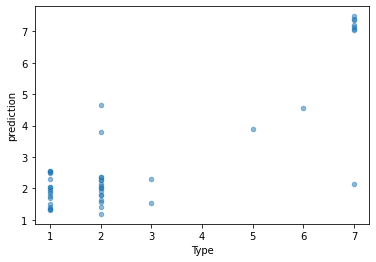

In [30]:
import pandas as pd

predict_diagram = predict.toPandas()
data = pd.concat([predict_diagram['Type'], predict_diagram['prediction']], axis=1)
data.plot.scatter(x='Type', y='prediction', alpha=0.5)